In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
from configs import CONFIGS
device = CONFIGS["device"]
batch_size = CONFIGS["batch_size"]
num_components = CONFIGS["num_components"]
loss_sample_batch_size = CONFIGS["loss_sample_batch_size"]
flatness_threshold_factor = np.e

print(f"Using device: {device}")

from models.mlp import MLP

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./mnist_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=CONFIGS["batch_size"],
    shuffle=True
)

eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

indices = np.random.permutation(len(train_dataset))[:loss_sample_batch_size]
indices = list(indices)

sub_loader = DataLoader(train_dataset, \
    batch_size=loss_sample_batch_size, sampler=SubsetRandomSampler(indices), shuffle=False)

model = MLP(input_dim=28*28, hidden_dim=50, output_dim=10).to(device)
optimizer = optim.SGD(model.parameters(), lr=CONFIGS["learning_rate"])
criterion = nn.CrossEntropyLoss()

def calculate_overall_loss(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            total_loss += criterion(output, target).item() * data.size(0)
            total_samples += data.size(0)

    if total_samples == 0:
        return 0.0
    return total_loss / total_samples

Using device: cuda


In [3]:
print("\nloading data, model, and PCA results...")
try:
    mean_weight = np.load('data/mean_weight.npy')
    pca_components = np.load('data/pca_components.npy')
    variances = np.load('data/pca_variances.npy')
    model_state_dict = torch.load('data/final_model.pth')
except FileNotFoundError as e:
    print(f"error: {e.filename} not found.")
    print("please run 'train_model.py' and 'run_pca.py' first.")
    exit()


loading data, model, and PCA results...


/tmp/ipykernel_12431/2886213566.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch.load('data/final_model.pth')


In [4]:
print("calculating baseline loss L0 on the data subset...")
w0_tensor = torch.tensor(mean_weight.reshape(50, 50), dtype=torch.float32).to(device)
model.load_state_dict(model_state_dict)
model.fc2.weight.data = w0_tensor

L0 = calculate_overall_loss(model, sub_loader, criterion, device)
flatness_threshold = L0 * flatness_threshold_factor
print(f"baseline loss L0 (on subset): {L0:.6f}")
print(f"flatness threshold (L0 * e): {flatness_threshold:.6f}")

if not os.path.exists('plots'):
    os.makedirs('plots')

calculating baseline loss L0 on the data subset...
baseline loss L0 (on subset): 0.000358
flatness threshold (L0 * e): 0.000973


index number: 100%|██████████| 4/4 [02:49<00:00, 42.33s/it]


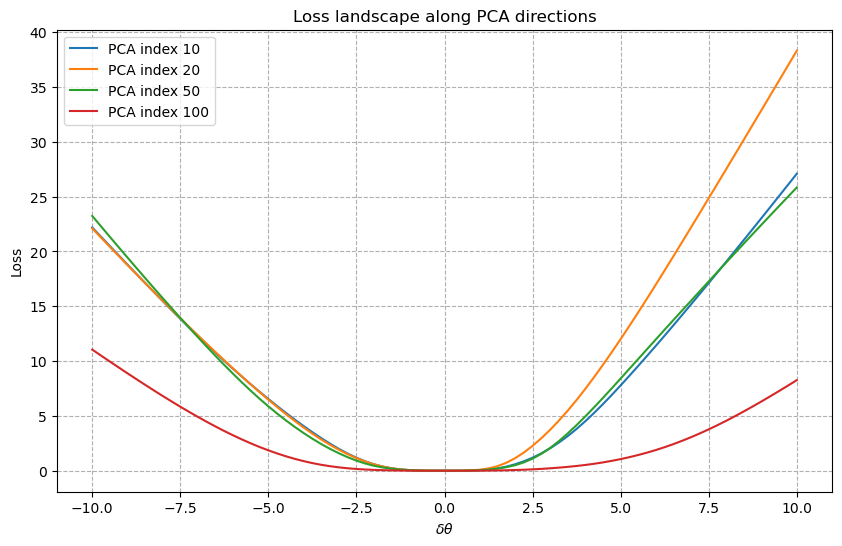

In [5]:
plt.figure(figsize=(10, 6))

analysis_indices = [10, 20, 50, 100]
dtheta_range = np.linspace(-10, 10, 81)

for i in tqdm(analysis_indices, desc="index number"):
    p_i = pca_components[i]
    p_i_tensor = torch.tensor(p_i.reshape(50, 50), dtype=torch.float32).to(device)

    losses = []
    for dtheta in tqdm(dtheta_range, desc="dtheta number", leave=False):
        model.fc2.weight.data = w0_tensor + dtheta * p_i_tensor
        loss = calculate_overall_loss(model, sub_loader, criterion, device)
        losses.append(loss)
    
    plt.plot(dtheta_range, losses, label=f"PCA index {i}")

plt.title("Loss landscape along PCA directions")
plt.xlabel(r"$\delta\theta$")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.savefig('plots/loss_landscapes.png')

plt.show()

In [12]:
print(variances.shape)
print(pca_components.shape)

(500,)
(500, 2500)


0.008523813


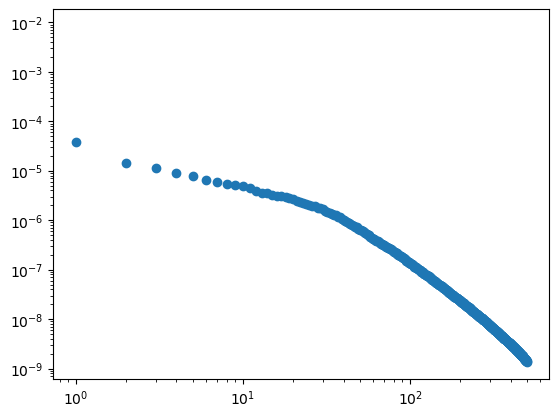

In [11]:
plt.figure()
plt.plot(variances, 'o')
plt.xscale("log")
plt.yscale("log")

print(variances[0])

plt.show()